In [2]:

path='G:/Shared drives/BeStarsMiMeS/UpdatedFiles/' #Patrick's google file stream path


# 0.1 Importing Packages

In [23]:
import pandas as pd
from IPython.display import display
import pyRaven as rav
import matplotlib.pyplot as plt
import h5py as h5
import pandas as pd
import itertools
import numpy as np

In [26]:
#Accessing the google sheets

sheet_id = '1M6y1Wnsrc-w5FjUMfKaSFa_-foIDAaMe8W4lYNWnWyk'
sheet_name = 'Stars'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
StarData=pd.read_csv(url)

sheet_name = 'Observations'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Observations=pd.read_csv(url)

In [27]:
StarData

,HD,Name,Nobs,T,log(g),ModelCode,Adopted-vsini,Halpha shape,Notes,BadvsiniFlag,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,6226.0,hd6226,1,15000,4.0,T15000g40,120.00,absorption,"no disk during observation, rotational modulation",1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7636.0,hd7636,2,15000,4.0,T15000g40,220.00,asymetric single,binary? no tess observation,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10144.0,hd10144,1,20000,3.5,T20000g35,245.31,bowl,binary or pulsator,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10516.0,hd10516,1,25000,4.0,T25000g40,382.04,asymetric double,sdO companion https://iopscience.iop.org/artic...,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11415.0,hd11415,1,18000,4.0,T18000g40,48.00,absorption,not a binary https://iopscience.iop.org/articl...,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,217891.0,hd217891,5,15000,3.0,T15000g30,95.00,single,not a binary https://iopscience.iop.org/articl...,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,221507.0,hd221507,1,10500,4.0,T10500g40,40.00,absorption,Not a Be star,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,224686.0,hd224686,2,13000,4.0,T13000g40,286.16,shell,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,239712.0,hd239712,1,21000,4.0,T21000g40,304.86,asymetric double,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Demo for single star
Before anything can be run through pyRaven the data for our stars must be put in a certain format. pyRaven is built to work with data packets that are saved as .h5 files. Within the pyRaven github there is a tutorial called `data_example.ipynb` which goes through the structure and creation of the data packet. 

Right now we can make the data packets for the hybrid-fullMask (hybrid_maskdepth0.02_tellClean) and obs-fullMask (normalized_maskdepth0.02_tellClean). Once the `12-LSDComparisions.ipynb` is completed, check with Vero to see if any more models should be be converted to data packets.

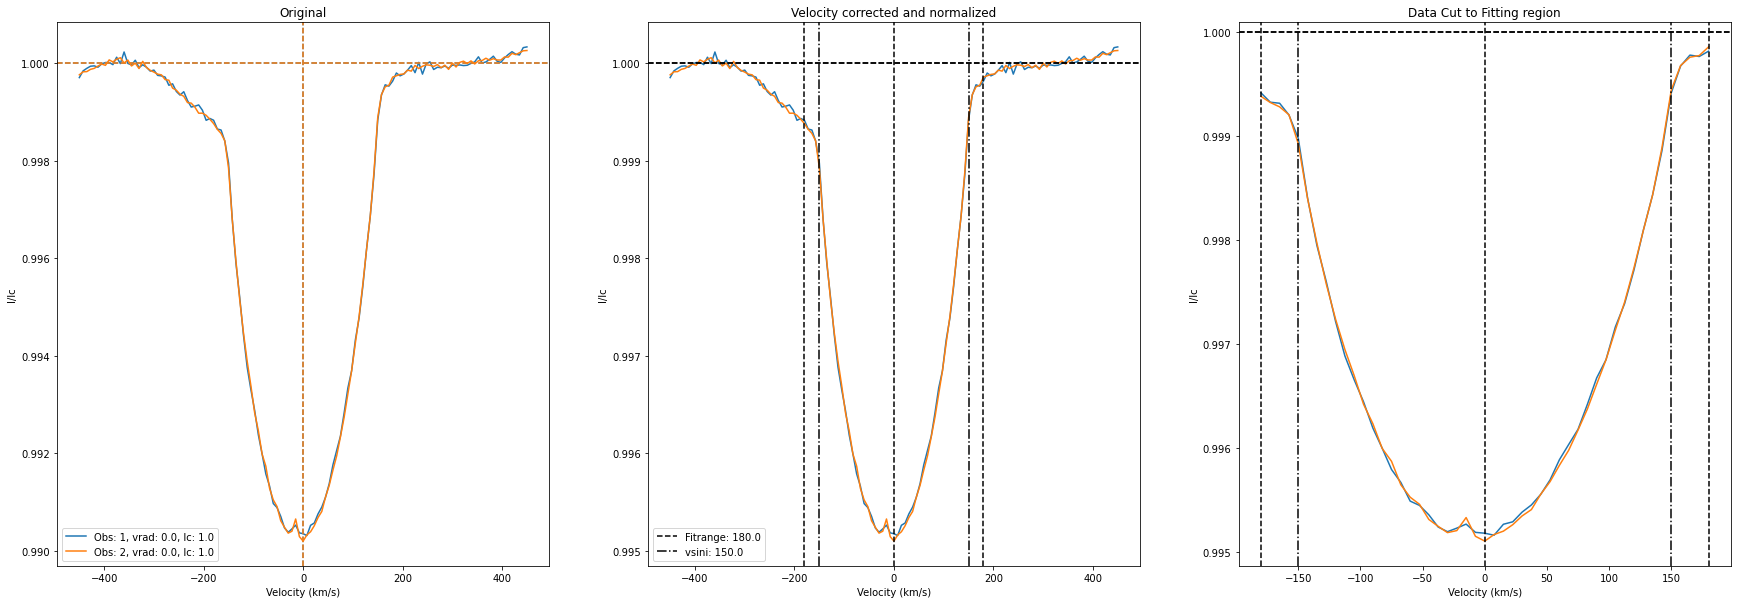

In [87]:
star_name = StarData['Name'][1] #Star name #StarData
nobs = StarData['Nobs'][1] #number of observations #StarData/Observations
fname = Observations[Observations['Name']==star_name]['LSDfileName'].to_numpy() #list of filenames #Observations
vrad = Observations[Observations['Name']==star_name]['Unnamed: 11'].to_numpy() #list of vrads #Observations
Ic = np.ones(nobs) #list of continuum normalization values (should be ~1) #LSD profile (.lsd file)
wint_data = np.ones(nobs)*0.2 #? #intesity weight for pyRaven #constant?
wpol_data = np.ones(nobs)*120 #? #polarization weight of data #constant?
wint_rav = 0.1 #intesity weight for pyRaven #constant?
wpol_rav = 60.0 #polarization weight for pyRaven #constant?
fitrange = 1.2*float(StarData['vsini-estimate'][1]) #size of the area to be used in the fit (just the line, no continuum)
vsini = float(StarData['vsini-estimate'][1]) #vsini of the star in km/s #StarData
fnames =['{}03-LSD-calculations/LSD/hybrid_maskdepth0.02_tellClean/{}'.format(path,x.split('.s')[0]) for x in fname]

lsds_original = rav.data.read_lsds_from_sfiles(fnames) #list of LSDs for a star, one for each observation
Packet = rav.data.create_Packet(star_name, nobs, fname, 
                    vrad, Ic, wint_data, wpol_data,
                    wint_rav, wpol_rav, fitrange, vsini,
                    lsds_original)

fig, ax = Packet.plotI()

Packet.write('{}05-RavenSetup/hybrid_maskdepth0.02_tellClean/{}.h5'.format(path,star_name))

# 2. hybrid_maskdepth0.02_tellClean

# 3. normalized_maskdepth0.02_tellClean